In [1]:
#IMPORTS
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate
from scipy.optimize import curve_fit


In [2]:
#HARDCODED VALUES
R_URANUS = 25559 #at 1bar level (i.e. surface) (equatorial) in km

/tmp/ipykernel_3830088/1825026631.py:13: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x - d * x**2)
/tmp/ipykernel_3830088/1825026631.py:16: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(decay_func, r, spl(r))


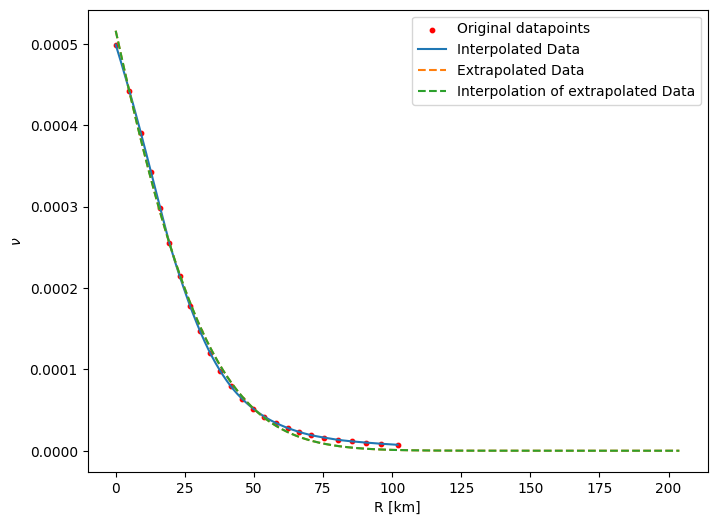

In [3]:
#Atmosphere nu values in 1D, interpolation and extrapolation on atmosphere and above


#generate data for interpolation
data = np.loadtxt("uranus_profile_default.csv", delimiter=',')
R_datapoints = data[:, 1]
nu_datapoints = data[:, 4]
spl = CubicSpline(R_datapoints, nu_datapoints)

r = np.linspace(np.min(R_datapoints), np.max(R_datapoints), 1000)

def decay_func(x, a, b, c, d):
    return a * np.exp(-b * x - d * x**2)

# Fit the curve to find optimal parameters
params, _ = curve_fit(decay_func, r, spl(r))

x_extrap = np.linspace(np.min(R_datapoints), 2*np.max(R_datapoints), 1000)
y_extrap = decay_func(x_extrap, *params)

r2 = np.linspace(np.min(R_datapoints), 2*np.max(R_datapoints), 5000)
spl2 = CubicSpline(x_extrap, y_extrap)

plt.figure(figsize=(8, 6))
plt.scatter(R_datapoints, nu_datapoints, s=10, c='r', label='Original datapoints')
plt.plot(r, spl(r), label='Interpolated Data')
plt.plot(x_extrap, y_extrap, label='Extrapolated Data', linestyle='dashed')
plt.plot(r2, spl2(r2), label='Interpolation of extrapolated Data', linestyle='dashed')

plt.xlabel('R [km]')
plt.ylabel(r'$\nu$')
plt.legend()
plt.show()

def calc_r(s, h):
    '''
    Calculates the distance to the center of the planet.
    Input values:
    s: path variable (-inf initially, 0 when passing the planet, infinity at the end)
    b: impact parameter
    '''
    b = R_URANUS + h
    
    return np.sqrt(s**2 + b**2)


def calc_nu(s, h):

    r = calc_r(s, h)
    h_atm = r - R_URANUS #go back to of atmosphere
    
    if (h_atm > 2*np.max(R_datapoints)):
        return 0

    else:
        return spl2(h_atm)


def calc_los(h):
    '''
    Calculates the line-of-sight integral
    Input values:
    b: Impact parameter
    '''
    return integrate.quad(lambda s: calc_nu(s, h), -np.inf, np.inf)[0]


calc_los_vectorized = np.vectorize(calc_los)


# Explanation how to use this script

### Use calc_los_vectorized and input an array of h values (height of the atmosphere, in km)
### It then returns the array for the change in the optical path (in km)

## Visualizes the Change in optical path for difference heights of the atmosphere in 1d

/tmp/ipykernel_3830088/1825026631.py:65: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda s: calc_nu(s, h), -np.inf, np.inf)[0]


Text(0, 0.5, 'Difference in optical path [km]')

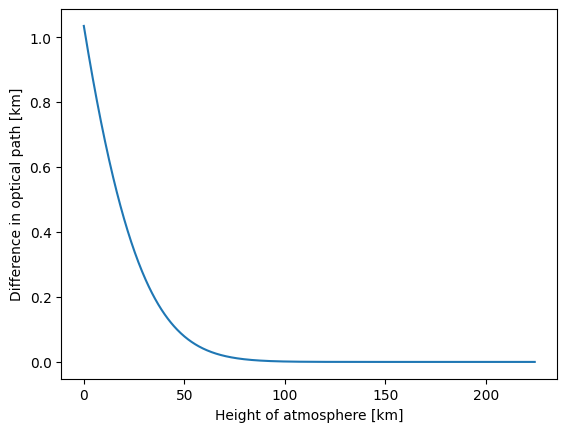

In [4]:
h_values = np.linspace(0, 2.2*np.max(R_datapoints), 1000)

plt.plot(h_values, calc_los_vectorized(h_values))
plt.xlabel("Height of atmosphere [km]")
plt.ylabel("Difference in optical path [km]")

## Visualizes the Change in optical path for difference heights of the atmosphere in 2d

/tmp/ipykernel_3830088/1825026631.py:65: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda s: calc_nu(s, h), -np.inf, np.inf)[0]


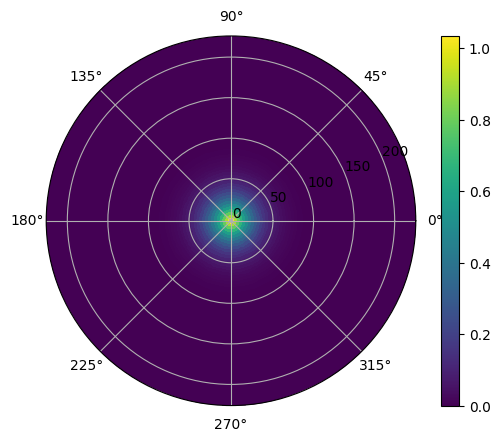

In [5]:
h_values = np.linspace(0, 2.2*np.max(R_datapoints), 64)
theta_values = np.linspace(0, 2*np.pi, 100)

h_values_grid, theta_values_grid = np.meshgrid(h_values, theta_values)

plt.subplot(projection='polar')
plt.pcolormesh(theta_values_grid, h_values_grid, calc_los_vectorized(h_values_grid))
plt.colorbar()

running


/tmp/ipykernel_3830088/45057011.py:65: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda x: calc_nu_3d(x, h, theta, phi), -1e5, 1e5)[0]


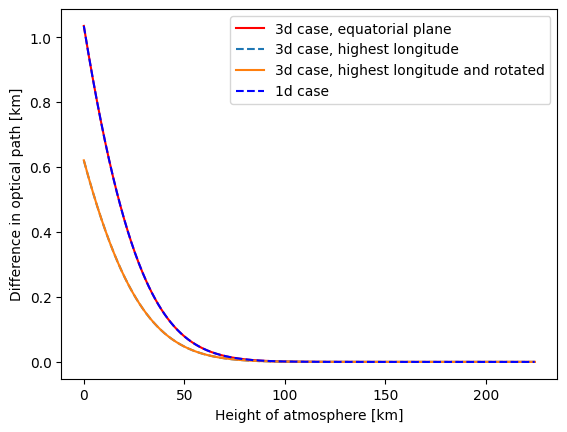

In [26]:
#IMPORTS
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate
from scipy.optimize import curve_fit

#HARDCODED VALUES
R_URANUS = 25559 #at 1bar level (i.e. surface) (equatorial) in km

print("running")

def trsf_to_planet_frame(x, h, theta, phi):
    #First step: From height in the atmosphere at the closest point to the planet, calcuclate its impact parameter
    b = R_URANUS + h

    #in the reference frame of the light path that travelles along x:
    s = np.array([x, 0, 0])

    #Change origin to center of planet:
    s_planet = s + np.array([0, 0, b])

    #Change to the planet frame via rotation matrices
    R_x = np.array([[1, 0            , 0             ],
                    [0, np.cos(theta), -np.sin(theta)],
                    [0, np.sin(theta),  np.cos(theta)]])
    R_z = np.array([[np.cos(phi), -np.sin(phi), 0],
                    [np.sin(phi), np.cos(phi), 0],
                    [0          , 0           , 1]])
    s_final = R_x @ R_z @ s_planet

    #Determine r, phi and theta at the location x in the frame of the planet
    r_final = np.linalg.norm(s_final)
    phi_final = np.arctan2(s_final[1], s_final[0])
    theta_final = np.arccos(s_final[2] / r_final)

    return r_final, phi_final, theta_final
    
def calc_nu_3d(x, h, theta, phi):

    #Determine r, phi and theta in the frame of the planet
    r_final, theta_final, phi_final = trsf_to_planet_frame(x, h, theta, phi) 

    h_atm_final = r_final - R_URANUS #go back to of atmosphere
    
    if (h_atm_final > 2*np.max(R_datapoints)):
        return 0
    
    else:
        return spl2(h_atm_final) * (1 - 0.4* theta / np.pi)
    
    

def calc_los_3d(h, theta, phi):
    #Calcualtes the additional path light takes due to refraction of the atmosphere.
    #
    #Input values:
    #h: position (in km) in the atmosphere starting from surface of the planet at the closest point (i.e. when we calculate the impact parameter b= R_p + h
    #Theta: Inclination of the plant w.r.t the path of light
    #Phi: Azimuthal angle w.r.t the path of light
    #
    #Output:
    #Change in optical path in km

    return integrate.quad(lambda x: calc_nu_3d(x, h, theta, phi), -1e5, 1e5)[0]

calc_los_3d_vectorized = np.vectorize(calc_los_3d)




h_values = np.linspace(0, 2.2*np.max(R_datapoints), 1000)
THETA = 0
PHI = 0

s_not_tilted = calc_los_3d_vectorized(h_values, THETA, PHI)

plt.plot(h_values, s, c='r', label='3d case, equatorial plane')

THETA = np.pi
PHI = 0
s_max_tilted = calc_los_3d_vectorized(h_values, THETA, PHI)
plt.plot(h_values, s_max_tilted, label='3d case, highest longitude', linestyle='dashed')

THETA = np.pi
PHI = np.pi/6
s_max_tilted_and_rotated = calc_los_3d_vectorized(h_values, THETA, PHI)
plt.plot(h_values, s_max_tilted_and_rotated, label='3d case, highest longitude and rotated')

#Comparison to 1d case (e.g. THETA = 0 and Phi = 0)
plt.plot(h_values, calc_los_vectorized(h_values), label='1d case', c='b', linestyle='dashed')
plt.xlabel("Height of atmosphere [km]")
plt.ylabel("Difference in optical path [km]")
plt.legend()